# Natural Language Inference: Fine-Tuning BERT

*This section is under construction.*

![This section feeds pretrained BERT to an MLP-based architecture for natural language inference.](../img/nlp-map-nli-bert.svg)

:label:`fig_nlp-map-nli-bert`


## Pretraining BERT

In [1]:
import d2l
import multiprocessing
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()
bert_batch_size, max_len = 256, 128
bert_train_iter, vocab = d2l.load_data_wiki(bert_batch_size, max_len)

In [2]:
ctx, loss = d2l.try_all_gpus(), gluon.loss.SoftmaxCELoss()
bert = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=128,
                     num_heads=2, num_layers=2, dropout=0.2)
bert.initialize(init.Xavier(), ctx=ctx)
d2l.train_bert(bert_train_iter, bert, loss, len(vocab), ctx, 20, 4000)

MLM loss 5.720, NSP loss 0.331
5574.5 sentence pairs/sec on [gpu(0), gpu(1)]


## The Dataset for Fine-Tuning BERT

In [3]:
class SNLIBERTDataset(gluon.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            d2l.tokenize(dataset[0]), d2l.tokenize(dataset[1]))]
        self.labels = np.array(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (np.array(all_token_ids, dtype='int32'),
                np.array(all_segments, dtype='int32'), 
                np.array(valid_lens))
    
    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

...

In [4]:
data_dir = d2l.download_extract('SNLI')
train_data = d2l.read_snli(data_dir, True)
test_data = d2l.read_snli(data_dir, False)
train_set = SNLIBERTDataset(train_data, max_len, vocab)
test_set = SNLIBERTDataset(test_data, max_len, vocab)

read 549367 examples


read 9824 examples


...

In [5]:
# Reduce `batch_size` if there is an out of memory error
batch_size, num_workers = 512, d2l.get_dataloader_workers()
train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

## Fine-Tuning BERT

In [6]:
class BERTClassifier(nn.Block):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.classifier = nn.Sequential()
        self.classifier.add(nn.Dense(256, activation='relu'))
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.classifier.add(nn.Dense(3))

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X, _, _ = self.bert(tokens_X, segments_X, valid_lens_x)
        return self.classifier(encoded_X[:, 0, :])

...

In [7]:
net = BERTClassifier(bert)
net.classifier.initialize(ctx=ctx)

Note that parameters in the fully-connected layers for both masked language model loss and next sentence prediction loss are not updated when BERT is fine-tuned.
To allow parameters with stale gradients,
the flag `ignore_stale_grad=True` is set in the `step` function of `d2l.train_batch_ch13`.

loss 0.848, train acc 0.598, test acc 0.594
10946.4 examples/sec on [gpu(0), gpu(1)]


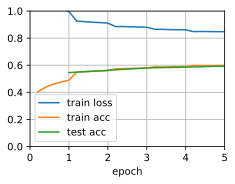

In [8]:
lr, num_epochs = 1e-4, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx,
               d2l.split_batch_multi_inputs)

## Summary

## Exercises

1. How to truncate a pair of sequences according to their ratio of
length.


## [Discussions](https://discuss.mxnet.io/t/5870)

![](../img/qr_natural-language-inference-bert.svg)